# Modeling and Simulation in Python

Chapter 10: Vectors

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

### Vectors

A `Vector` object is like a combination of a NumPy array and a Pint Quantity.

I'll start by grabbing the units we'll need.

In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

Here's a two dimensional `Vector` in meters.

In [4]:
A = Vector(3, 4) * m

We can access the elements by name.

In [5]:
A.x

<Quantity(3.0, 'meter')>

In [5]:
A.y

<Quantity(4.0, 'meter')>

The magnitude is the length of the vector.

In [6]:
A.mag

<Quantity(5.0, 'meter')>

The angle is the number of radians between the vector and the positive x axis.

In [7]:
A.angle

<Quantity(0.9272952180016122, 'radian')>

If we make another `Vector` with the same units,

In [8]:
B = Vector(1, 2) * m

We can add `Vector` objects like this

In [9]:
A + B

<Quantity([ 4.  6.], 'meter')>

And substract like this:

In [10]:
A - B

<Quantity([ 2.  2.], 'meter')>

We can compute the Euclidean distance between two Vectors.

In [11]:
A.dist(B)

<Quantity(2.8284271247461903, 'meter')>

And the difference in angle

In [12]:
A.diff_angle(B)

<Quantity(-0.17985349979247822, 'radian')>

If we are given the magnitude and angle of a vector, what we have is the representation of the vector in polar coordinates.

In [13]:
mag = A.mag
angle = A.angle

We can use `pol2cart` to convert from polar to Cartesian coordinates, and then use the Cartesian coordinates to make a `Vector` object.

In this example, the `Vector` we get should have the same components as `A`.

In [14]:
x, y = pol2cart(angle, mag)
Vector(x, y)

<Quantity([ 3.  4.], 'meter')>

**Exercise:** Create a `Vector` named `a_grav` that represents acceleration due to gravity, with x component 0 and y component $-9.8$ meters / second$^2$.

In [15]:
a_grav = Vector(0, -9.8*m/s**2)
a_grav

<Quantity([ 0.  -9.8], 'meter / second ** 2')>

### Degrees and radians

Pint provides units to represent degree and radians.

In [16]:
degree = UNITS.degree
radian = UNITS.radian

If you have an angle in degrees,

In [17]:
angle = 45 * degree
angle

<Quantity(45, 'degree')>

You can convert to radians.

In [18]:
angle_rad = angle.to(radian)
angle_rad

<Quantity(0.7853981633974483, 'radian')>

If it's already in radians, `to` does the right thing.

In [19]:
angle_rad.to(radian)

<Quantity(0.7853981633974483, 'radian')>

You can also convert from radians to degrees.

In [20]:
angle_rad.to(degree)

<Quantity(45.0, 'degree')>

As an alterative, you can use `np.deg2rad`, which works with Pint quantities, but it also works with simple numbers and NumPy arrays:

In [21]:
np.deg2rad(angle)

<Quantity(0.7853981633974483, 'radian')>

**Exercise:** Create a `Vector` named `a_force` that represents acceleration due to a force of 0.5 Newton applied to an object with mass 0.3 kilograms, in a direction 45 degrees up from the positive x-axis.

Add `a_force` to `a_drag` from the previous exercise.  If that addition succeeds, that means that the units are compatible.  Confirm that the total acceleration seems to make sense.

In [22]:
N = UNITS.newton
mag = 0.5*N
angle = 45 * degree
theta = angle.to(radian)
x, y = pol2cart(theta, mag)
force = Vector(x, y)
mass = 0.3 * kg
a_force = force / mass
a_force

<Quantity([ 1.1785113  1.1785113], 'newton / kilogram')>

In [23]:
a_force + a_grav

<Quantity([ 1.1785113 -8.6214887], 'newton / kilogram')>

### Baseball

Here's a `Condition` object that contains the parameters for the Manny Ramirez problem.

In [39]:
condition = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 145e-3 * kg,
                      diameter = 73e-3 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.3,
                      angle = 60 * degree,
                      velocity = 40 * m / s,
                      duration = 5.1 * s)

And here's the function that uses the `Condition` object to make a `System` object.

In [40]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

Here's how we use it:

In [41]:
system = make_system(condition)
system

,value
init,x 0 meter y ...
g,9.8 meter / second ** 2
mass,0.145 kilogram
area,0.004185386812745002 meter ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.3
ts,"[0.0 second, 0.051 second, 0.102 second, 0.153..."


Here's the slope function that computes acceleration due to gravity and drag.

In [42]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

Always test the slope function with the initial conditions.

In [43]:
slope_func(system.init, 0, system)

(<Quantity(20.000000000000004, 'meter / second')>,
 <Quantity(34.64101615137754, 'meter / second')>,
 <Quantity(-4.156522076105382, 'meter / second ** 2')>,
 <Quantity(-16.999307418596192, 'meter / second ** 2')>)

Now we can run `odeint`

In [44]:
run_odeint(system, slope_func)

Here are the first few time steps.

In [45]:
system.results.head()

,x,y,vx,vy
0.000,0.000000,1.000000,20.000000,34.641016
0.051,1.014652,2.744728,19.791366,33.782454
0.102,2.018830,4.446088,19.589256,32.940213
0.153,3.012862,6.104895,19.393417,32.113594
0.204,3.997061,7.721929,19.203610,31.301934


And the last few.  The last value of `y` is negative, indicating that the ball hit the ground before the end of the simulation.

In [46]:
system.results.tail()

,x,y,vx,vy
4.896,73.206233,26.827989,11.804811,-18.161004
4.947,73.806546,25.891722,11.736793,-18.554717
4.998,74.403377,24.935471,11.668255,-18.944701
5.049,74.996699,23.959427,11.599213,-19.330920
5.100,75.586488,22.963782,11.529681,-19.713338


### Visualizing the results

We can extract the x and y components as `Series` objects.

In [47]:
xs = system.results.x
ys = system.results.y

The simplest way to visualize the results is to plot x and y as functions of time.

<IPython.core.display.Javascript object>


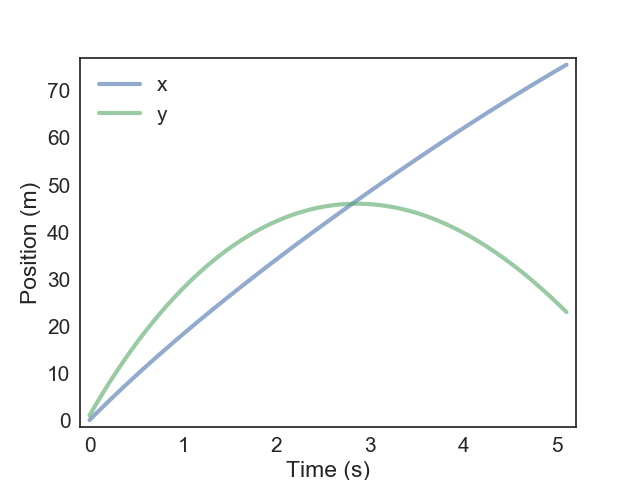

Saving figure to file chap10-fig01.pdf


In [48]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

savefig('chap10-fig01.pdf')

We can plot the velocities the same way.

In [49]:
vxs = system.results.vx
vys = system.results.vy

The x velocity slows down due to drag.  The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

<IPython.core.display.Javascript object>


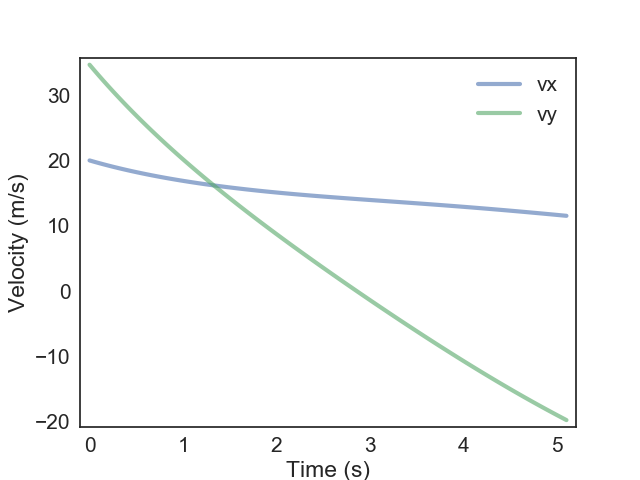

In [50]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

<IPython.core.display.Javascript object>


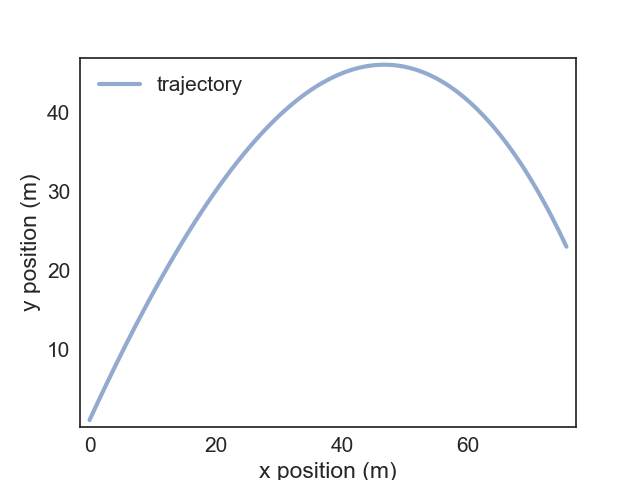

Saving figure to file chap10-fig02.pdf


In [51]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

savefig('chap10-fig02.pdf')

We can also animate the flight of the ball.  If there's an error in the simulation, we can sometimes spot it by looking at animations.

<IPython.core.display.Javascript object>


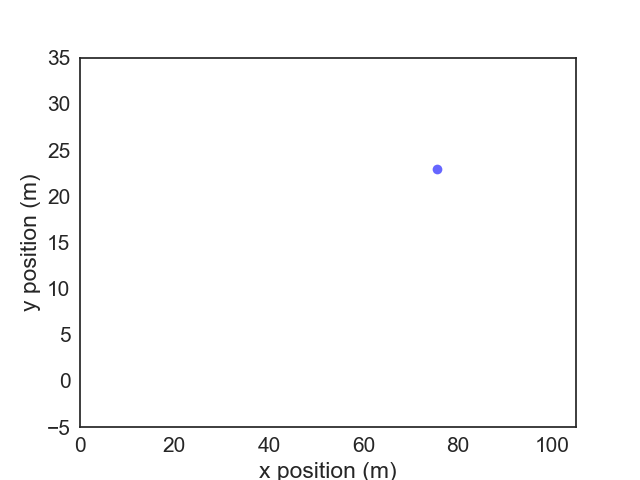

In [52]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 105],
         ylim=[-5, 35],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

Here's a function that encapsulates that code and runs the animation in (approximately) real time.

In [53]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

<IPython.core.display.Javascript object>


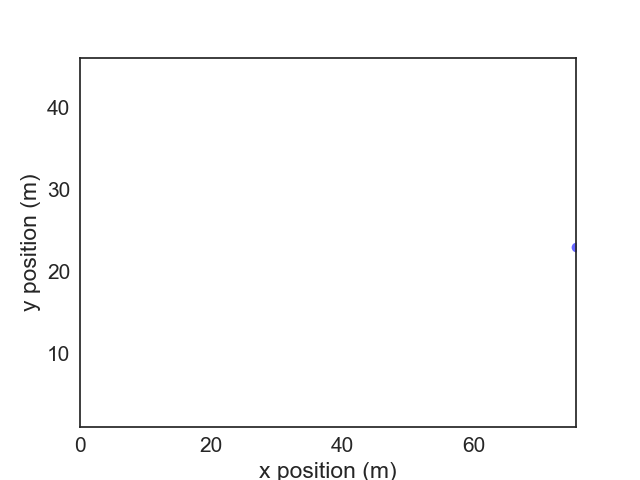

In [54]:
animate2d(system.results.x, system.results.y)

**Exercise:** Run the simulation for a few different launch angles and visualize the results.  Are they consistent with your expectations?

### Finding the range

Next we'll find the time and distance when the ball hits the ground.

In [55]:
condition.set(duration=7*s)
system = make_system(condition)
run_odeint(system, slope_func)

We have to interpolate y to find the landing time, then interpolate x to find the range.

In [56]:
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

Here's the result.

In [57]:
interpolate_range(system.results)

array(86.32037231617414)

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

In [59]:
# Hint: rather than modify `condition`, make a copy

condition2 = Condition(condition)

In [60]:
condition2.set(rho=1*kg/m**3)
system = make_system(condition2)
run_odeint(system, slope_func)
interpolate_range(system.results)

array(91.95703077946803)

### Optimal launch angle

To find the launch angle that maximizes range, we need a function that takes launch angle and returns range.

In [68]:
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    return x_range
angle

41.602768913470968

Let's test `range_func`.

In [69]:
%time range_func(45, condition)

Wall time: 337 ms


array(109.07212101030548)

And sweep through a range of angles.

In [70]:
angles = linspace(30, 60, 11)
sweep = SweepSeries()

for angle in angles:
    x_range = range_func(angle, condition)
    print(angle, x_range)
    sweep[angle] = x_range

30.0 102.22512880611951
33.0 105.61073422582602
36.0 107.97200490961362
39.0 109.32525682573122
42.0 109.68662225002511
45.0 109.07212101030548
48.0 107.49791212235652
51.0 104.98068732786591
54.0 101.53816371252147
57.0 97.1896982361027
60.0 91.95703077946803


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

<IPython.core.display.Javascript object>


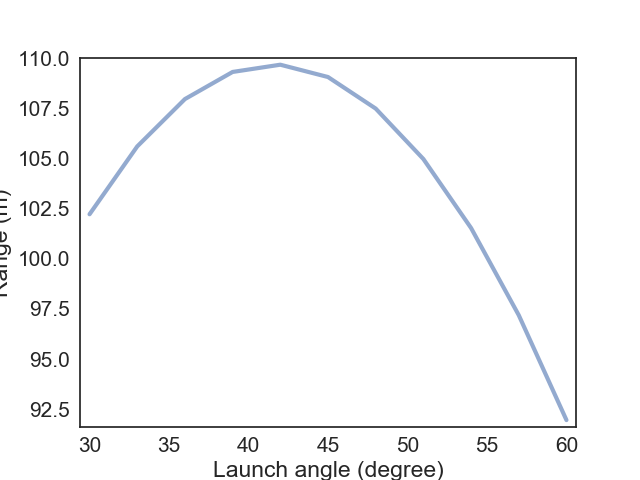

Saving figure to file chap10-fig03.pdf


In [71]:
newfig()
plot(sweep)
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         legend=False)

savefig('chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [72]:
%time res = max_bounded(range_func, [0, 90], condition)

Wall time: 3.71 s


The result is an `OptimizeResult` object.

In [73]:
type(res)

scipy.optimize.optimize.OptimizeResult

With the following variables.

In [74]:
res

     fun: 109.69517452156008
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 41.603102863878036

So the optimal angle is about 41 degrees, and the resulting range is 103 meters.

**Exercise:** Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

### Turning off units

Each time `range_func` runs, it calls `odeint`, which runs `slope_func` many times.  And each time `slop_func` runs, it checks the units for all computations, which takes some time.  We can speed up the whole process by removing the units from the computation (now that we are satisfied that they are correct).

Because of the way we organized the code, all units are in the `Condition` object, so we can "turn off units" by defining a new `Condition` object with no units:

In [75]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      C_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 7)

Now `range_func` and `max_bounded` are substantially faster.

In [76]:
%time range_func(45, condition)

Wall time: 48 ms


array(102.72237841710975)

In [77]:
%time res = max_bounded(range_func, [0, 90], condition)

Wall time: 436 ms


### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it launches at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a condition as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [79]:
def height_func(angle, condition):
    """Computes the height of the ball at the wall.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: height in meters
    """
    print(angle)
    
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    
    T = interp_inverse(system.results.x)
    t_wall = T(94.5)
    
    Y = interpolate(system.results.y)
    return Y(t_wall)
    

Test your function with a launch angle of 45 degrees:

In [80]:
height_func(45, condition)

45


array(11.025366370142653)

Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [81]:
res = max_bounded(height_func, [0, 90], condition)

45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748


The following lines compute the height of the ball at the wall, given that it's launched at the optimal angle.

In [82]:
angle = res.x
height = height_func(angle, condition)
height

44.5199261685


array(11.045254540088495)

Next, we need to find the height of the ball at the wall, for a given velocity, given that it's launched at the optimal angle.

Write a function called `best_height` that takes velocity and a `Condition` object as parameters.  It should use `max_bounded` to find the optimal launch angle, then compute and the highest possible height of the ball at the wall, for the given velocity.

In [83]:
def best_height(velocity, condition):
    """Returns the optimal height at the wall.
    
    velocity: initial velocity in m/s
    condition: Condition object
    
    returns: height in meters
    """
    condition.set(velocity=velocity)
    res = max_bounded(height_func, [0, 90], condition)
    
    angle = res.x
    height = height_func(angle, condition)
    return height

Use this code to test `best_height`

In [84]:
best_height(40, condition)

45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748
44.5199261685


array(11.045254540088495)

Finally, we want to use `fsolve` to find the initial velocity that makes the height of the ball exactly 11 meters when it reaches the wall.

To use `fsolve`, we need an error function that returns 0 when we have the right velocity.  Write a function called `error_func` that takes a velocity and a `Condition` object, uses `best_height` to find the height of the ball at the wall, and returns the difference between the result and the target value (11 meters).

In [85]:
def error_func(velocity, condition):
    """Difference between actual and desired height.
    
    velocity: initial velocity in m/s
    condition: Condition object
    
    returns: error in meters
    """
    height = best_height(velocity, condition)
    return height - 11

Test your error function like this:

In [86]:
error_func(40, condition)

45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748
44.5199261685


0.045254540088494721

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [87]:
min_velocity = fsolve(error_func, 40, condition)

45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748
44.5199261685
45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748
44.5199261685
45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.5182828595
44.47434319
44.5178199739
44.526924287
44.5215835911
44.5199261685
44.5202601622
44.5195921748
44.5199261685
45.0
34.3769410125
55.6230589875
21.246117975
40.0964091144
41.9865507741
47.1952334237
44.3729100433
44.4032473114
44.7851090803
44.5491055281
44.598163681
44.

In [88]:
min_velocity

array([ 39.98870758])

And just to check, run `best_height` with the value you found.  The result should be 11 meters.

In [89]:
best_height(min_velocity, condition)

45.0
34.3769410125
55.6230589875
21.246117975
40.0776743821
41.9731436079
47.1869473394
44.3597781642
44.3904172148
44.7735608061
44.5367650441
44.5793373047
44.5041005812
44.4606773992
44.5045373037
44.5135691447
44.5079871599
44.5061046433
44.5064386368
44.5057706498
44.5061046433


array(11.000000000003928)